In [1]:
import pandas as pd
import numpy as np
import os
import dill
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import dill
from sklearn.metrics import accuracy_score

# Functions

In [2]:
years = [2014, 2015, 2016, 2017, 2018]

states = [
    "AL",
    "AK",
    "AZ",
    "AR",
    "CA",
    "CO",
    "CT",
    "DE",
    "FL",
    "GA",
    "HI",
    "ID",
    "IL",
    "IN",
    "IA",
    "KS",
    "KY",
    "LA",
    "ME",
    "MD",
    "MA",
    "MI",
    "MN",
    "MS",
    "MO",
    "MT",
    "NE",
    "NV",
    "NH",
    "NJ",
    "NM",
    "NY",
    "NC",
    "ND",
    "OH",
    "OK",
    "OR",
    "PA",
    "RI",
    "SC",
    "SD",
    "TN",
    "TX",
    "UT",
    "VT",
    "VA",
    "WA",
    "WV",
    "WI",
    "WY",
    "PR",
]

In [3]:
dill_file = open(f"/raid/lcorbucci/folktables/employment_data.pkd", "rb")
data = dill.load(dill_file)

In [4]:
all_features = [
    "SCHL",
    "MAR",
    "SEX",
    "MIL",
    "CIT",
    "MIG",
    "ESP",
    "DIS",
    "ANC",
    "NATIVITY",
    "RELP",
    "DEAR",
    "DEYE",
    "DREM",
    "RAC1P",
    "AGEP",
]
categorical_columns = [
    "SCHL",
    "MIL",
    "CIT",
    "MIG",
    "ESP",
    "ANC",
    "RELP",
    "RAC1P",
]
continuous_columns = ["AGEP"]
col = "ESR"

In [5]:
csv_files = []
dataframes = []
labels = []
groups = []
dataset = pd.DataFrame()
for state in states:
    dataframe = pd.DataFrame()

    # Process data for each year
    for year in years:
        year = int(year)
        df = data[state][year]["features_pd"]
        df["SEX"] = data[state][year]["groups_pd"]
        df["ESR"] = (data[state][year]["labels_pd"]).astype(int)
        df["MAR"] = df["MAR"].apply(lambda x: 1 if x == 1 else 0)
        dataframe = pd.concat([dataframe, df])

    dataframe.dropna(inplace=True)

    csv_files.append(dataframe)


for state, csv_file in zip(states, csv_files):
    csv_file.to_csv(
        f"/raid/lcorbucci/folktables/employment_data_reduced/{state}.csv", index=False
    )

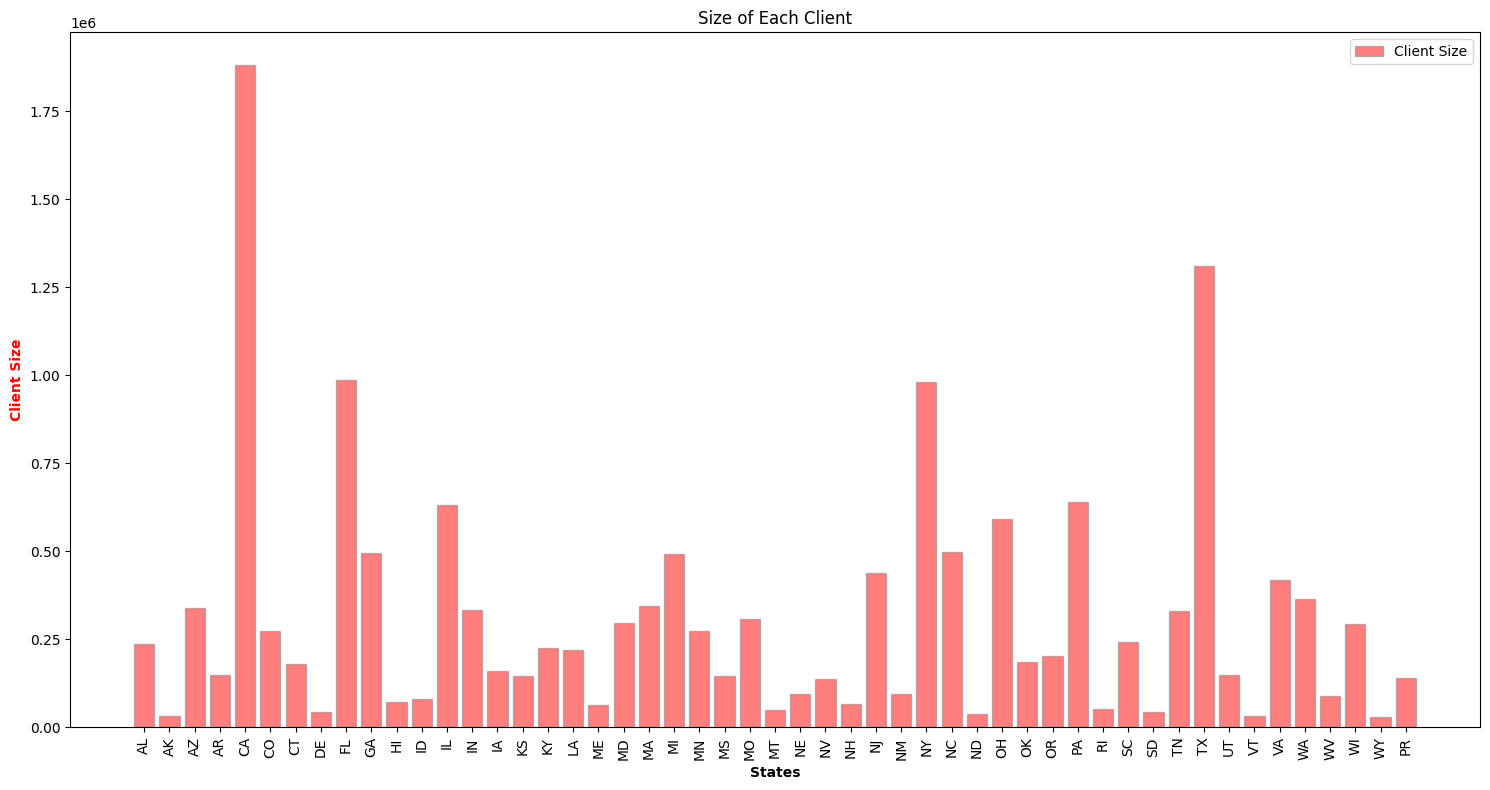

In [6]:
import matplotlib.pyplot as plt

r = np.arange(len(states))
# Plot the size of each client
fig, ax2 = plt.subplots(figsize=(15, 8))

# Create the bars for client size
client_sizes = [len(df) for df in csv_files]
bars2 = ax2.bar(
    r, client_sizes, color="red", edgecolor="grey", alpha=0.5, label="Client Size"
)

# Add labels for client size
ax2.set_xlabel("States", fontweight="bold")
ax2.set_ylabel("Client Size", fontweight="bold", color="red")
ax2.set_title("Size of Each Client")
ax2.set_xticks(r)
ax2.set_xticklabels(states, rotation=90)

# Add legends
ax2.legend(loc="upper right")

# Show the plot
plt.tight_layout()
plt.show()

In [7]:
sum([len(df) for df in csv_files])

15949380

In [8]:
# accuracy_list = []
# states_details = {}
# # Train logistic regression for each csv file
# for state in states:
#     if os.path.exists(
#         f"/raid/lcorbucci/folktables/employment_data_reduced/{state}_model.pkl"
#     ):
#         model = dill.load(
#             open(
#                 f"/raid/lcorbucci/folktables/employment_data_reduced/{state}_model.pkl",
#                 "rb",
#             )
#         )
#         states_details[state]["model"] = {
#             "trained_model": model,
#         }
#     else:
#         df = pd.read_csv(
#             f"/raid/lcorbucci/folktables/employment_data_reduced/{state}.csv"
#         )
#         X = df[all_features]
#         Y = df[col]

#         X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

#         model = LogisticRegression()
#         model.fit(X_train, Y_train)

#         Y_pred = model.predict(X_test)
#         accuracy = accuracy_score(Y_test, Y_pred)
#         accuracy_list.append(accuracy)
#         if state not in states_details:
#             states_details[state] = {}
#         if "model" not in states_details[state]:
#             states_details[state]["model"] = {}
#         states_details[state]["model"]["trained_model"] = model
#         dill.dump(
#             model,
#             open(
#                 f"/raid/lcorbucci/folktables/employment_data_reduced/{state}_model.pkl",
#                 "wb",
#             ),
#         )

# Prepare data for training with FL

In [9]:
from sklearn.preprocessing import TargetEncoder

In [10]:
def pre_process_employment(df):
    """
    Pre-process the income dataset to make it ready for the simulation
    In this function we consider "SEX" as the sensitive value and "PINCP" as the target value.

    Args:
        data: the raw data
        years_list: the list of years to be considered
        states_list: the list of states to be considered

    Returns:
        Returns a list of pre-processed data for each state, if multiple years are
        selected, the data are concatenated.
        We return three lists:
        - The first list contains a pandas dataframe of features for each state
        - The second list contains a pandas dataframe of labels for each state
        - The third list contains a pandas dataframe of groups for each state
        The values in the list are numpy array of the dataframes
    """

    categorical_columns = [
        "SCHL",
        "MIL",
        "CIT",
        "MIG",
        "ESP",
        "ANC",
        "RELP",
        "RAC1P",
    ]
    continuous_columns = ["AGEP"]

    # get the target and sensitive attributes
    target_attributes = df["ESR"]
    sensitive_attributes = df["SEX"]

    # convert the columns to one-hot encoding
    encoder = TargetEncoder()
    df[categorical_columns] = encoder.fit_transform(
        df[categorical_columns], target_attributes
    )

    # normalize the continuous columns between 0 and 1
    for col in continuous_columns:
        df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

    return pd.DataFrame(df)


def pre_process_single_datasets(df):
    dataframe = pd.DataFrame()
    label = pd.DataFrame()
    group = pd.DataFrame()
    second_group = pd.DataFrame()
    dataframes = []
    labels = []
    groups = []
    second_groups = []

    target_attributes = df["ESR"]
    sensitive_attributes = df["SEX"]
    second_sensitive_attributes = df["MAR"]
    target_attributes = target_attributes.astype(int)

    sensitive_attributes = [1 if item == 1 else 0 for item in sensitive_attributes]

    second_sensitive_attributes = [
        1 if item == 1 else 0 for item in second_sensitive_attributes
    ]

    df = df.drop(["ESR"], axis=1)

    # concatenate the dataframes
    dataframe = pd.concat([dataframe, df])
    # convert the labels and groups to dataframes
    label = pd.concat([label, pd.DataFrame(target_attributes)])
    group = pd.concat([group, pd.DataFrame(sensitive_attributes)])
    second_group = pd.concat([second_group, pd.DataFrame(second_sensitive_attributes)])

    assert len(dataframe) == len(label) == len(group) == len(second_group)
    dataframes.append(dataframe.to_numpy())
    labels.append(label.to_numpy())
    groups.append(group.to_numpy())
    second_groups.append(second_group.to_numpy())
    return dataframes, labels, groups, second_groups

In [11]:
reduced_df_list = []
accuracy_list = []
for state in states:
    df = pd.read_csv(f"/raid/lcorbucci/folktables/employment_data_reduced/{state}.csv")

    dataset_size = len(df)
    frac = 20000
    if dataset_size > frac:
        df = df.sample(n=frac, random_state=42)

    # store to disk the sampled dataset
    df.to_csv(
        f"/raid/lcorbucci/folktables/employment_data_reduced/{state}_reduced.csv",
        index=False,
    )
    reduced_df_list.append(df)
    # X = df[all_features]
    # Y = df[col]

    # X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

    # model = LogisticRegression()
    # model.fit(X_train, Y_train)

    # Y_pred = model.predict(X_test)
    # accuracy = accuracy_score(Y_test, Y_pred)
    # accuracy_list.append(accuracy)

In [12]:
# do the one hot encoding
concatenated_df = pd.concat(reduced_df_list, ignore_index=True)
# Apply one-hot encoding
pre_processed_df = pre_process_employment(concatenated_df)

split_dfs = []
start_idx = 0
for df in reduced_df_list:
    end_idx = start_idx + len(df)
    split_dfs.append(pre_processed_df.iloc[start_idx:end_idx])
    start_idx = end_idx

In [13]:
for index, state in enumerate(split_dfs):
    data, labels, groups, _ = pre_process_single_datasets(state)

    if not os.path.exists(
        f"/raid/lcorbucci/folktables/employment_data_reduced/federated/{index}"
    ):
        os.makedirs(
            f"/raid/lcorbucci/folktables/employment_data_reduced/federated/{index}"
        )

    np.save(
        f"/raid/lcorbucci/folktables/employment_data_reduced/federated/{index}/employment_dataframes_{index}.npy",
        data[0],
    )

    np.save(
        f"/raid/lcorbucci/folktables/employment_data_reduced/federated/{index}/employment_labels_{index}.npy",
        labels[0],
    )

    np.save(
        f"/raid/lcorbucci/folktables/employment_data_reduced/federated/{index}/employment_groups_{index}.npy",
        groups[0],
    )

In [ ]:
accuracy_list = []
for df in split_dfs:
    X = df[all_features]
    Y = df[col]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

    model = LogisticRegression()
    model.fit(X_train, Y_train)

    Y_pred = model.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    accuracy_list.append(accuracy)

In [15]:
from collections import Counter

coun_list = []
for df in split_dfs:
    count_values = Counter(list(df["ESR"]))
    coun_list.append(count_values)

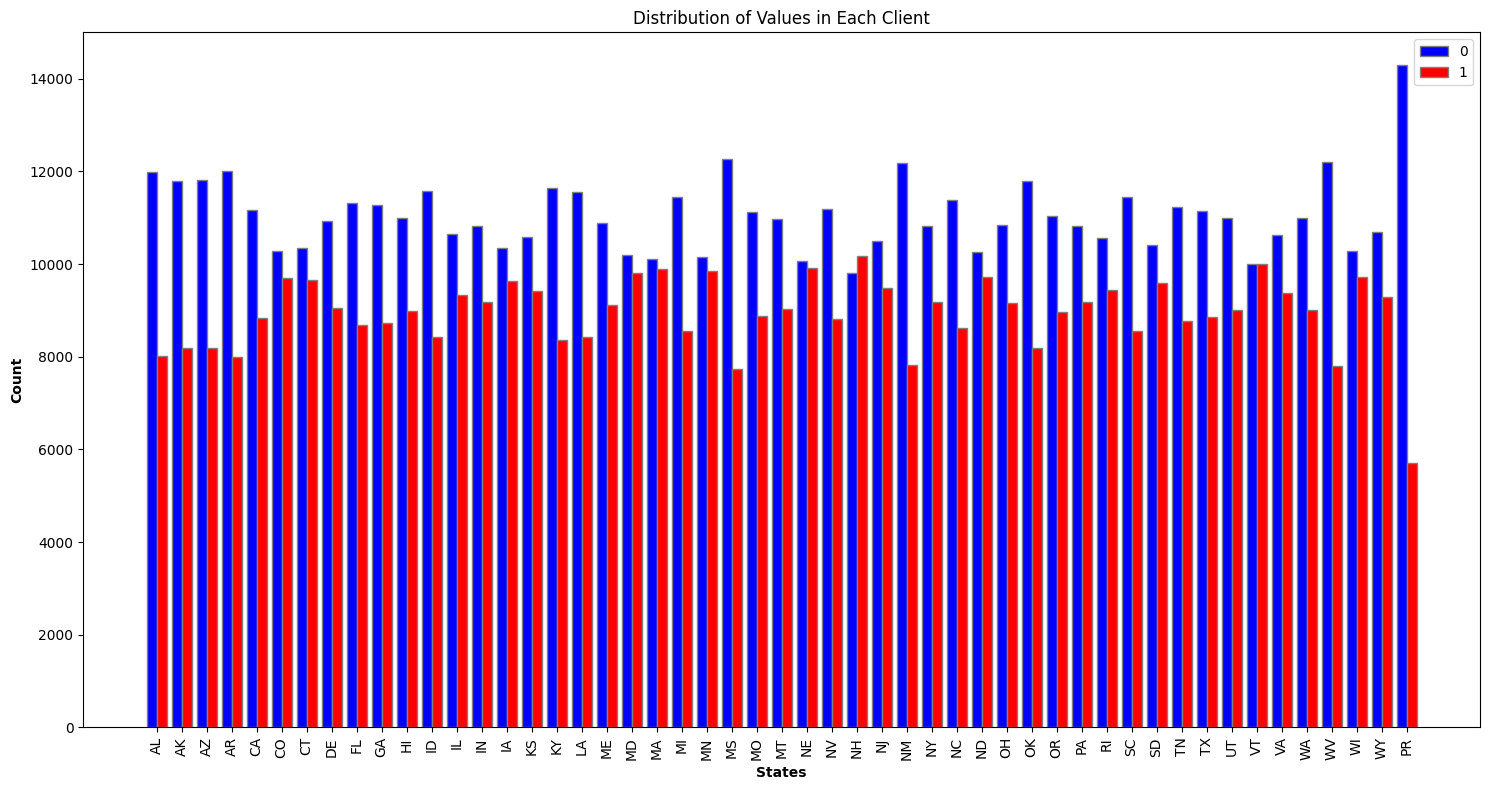

In [16]:
import matplotlib.pyplot as plt

# Plot the distribution of values in coun_list for each client
fig, ax = plt.subplots(figsize=(15, 8))

# Set the positions of the bars on the x-axis
r = np.arange(len(states))

# Extract the counts for each value (0 and 1) from coun_list
counts_0 = [counter[0] for counter in coun_list]
counts_1 = [counter[1] for counter in coun_list]

# Create the bars for each value
bars1 = ax.bar(r - 0.2, counts_0, width=0.4, color="blue", edgecolor="grey", label="0")
bars2 = ax.bar(r + 0.2, counts_1, width=0.4, color="red", edgecolor="grey", label="1")

# Add labels for the plot
ax.set_xlabel("States", fontweight="bold")
ax.set_ylabel("Count", fontweight="bold")
ax.set_title("Distribution of Values in Each Client")
ax.set_xticks(r)
ax.set_xticklabels(states, rotation=90)

# Add legends
ax.legend(loc="upper right")

# Show the plot
plt.tight_layout()
plt.show()

In [17]:
split_dfs[0].head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,0.701031,0.571240,0,0.584761,2.0,0.549834,0.439788,0.452672,0.572792,0.450757,1.0,2.0,2.0,2.0,2,0.387633,0
1,0.195876,0.313738,0,0.670965,2.0,0.549834,0.439788,0.449558,0.572792,0.403986,1.0,2.0,2.0,2.0,2,0.387633,0
2,0.350515,0.495088,0,0.585506,2.0,0.549947,0.439769,0.452311,0.572730,0.450746,1.0,2.0,2.0,2.0,2,0.460258,0
3,0.804124,0.495088,0,0.000000,1.0,0.549947,0.439769,0.452311,0.572730,0.489587,1.0,1.0,2.0,2.0,2,0.460258,0
4,0.134021,0.044853,0,0.181907,2.0,0.012882,0.439769,0.452311,0.010697,0.403872,1.0,2.0,2.0,2.0,2,0.341426,0


In [18]:
print(accuracy_list)

[0.78575, 0.783, 0.788, 0.79275, 0.78175, 0.80475, 0.7845, 0.7785, 0.799, 0.79775, 0.802, 0.8115, 0.81025, 0.80075, 0.819, 0.7975, 0.79525, 0.7835, 0.80575, 0.80725, 0.8095, 0.786, 0.8205, 0.7945, 0.813, 0.79125, 0.8115, 0.79, 0.789, 0.78975, 0.78, 0.7845, 0.792, 0.82475, 0.80525, 0.80175, 0.798, 0.80075, 0.78575, 0.78, 0.82625, 0.79675, 0.80525, 0.809, 0.76275, 0.7965, 0.79225, 0.79725, 0.81875, 0.795, 0.785]


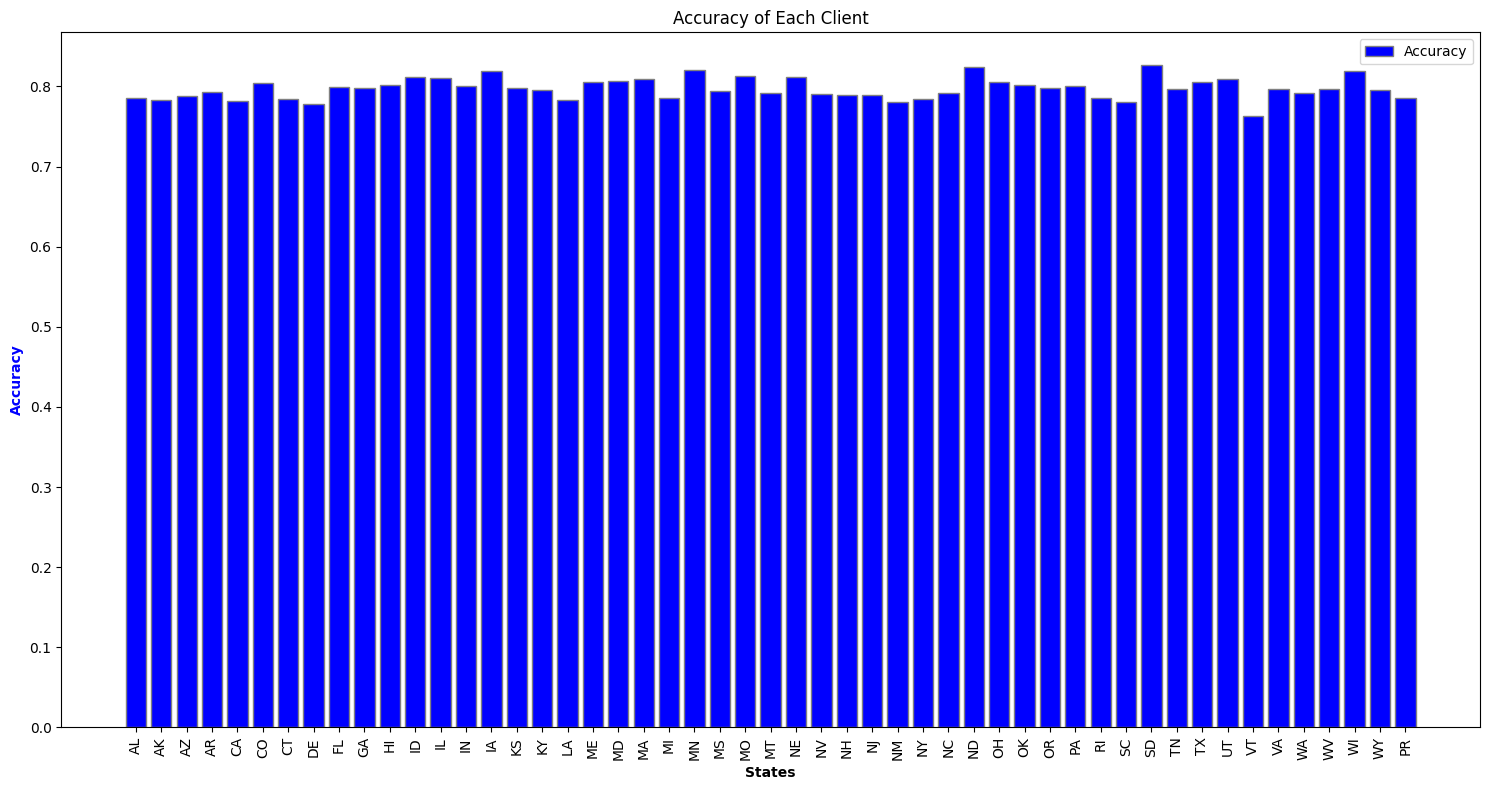

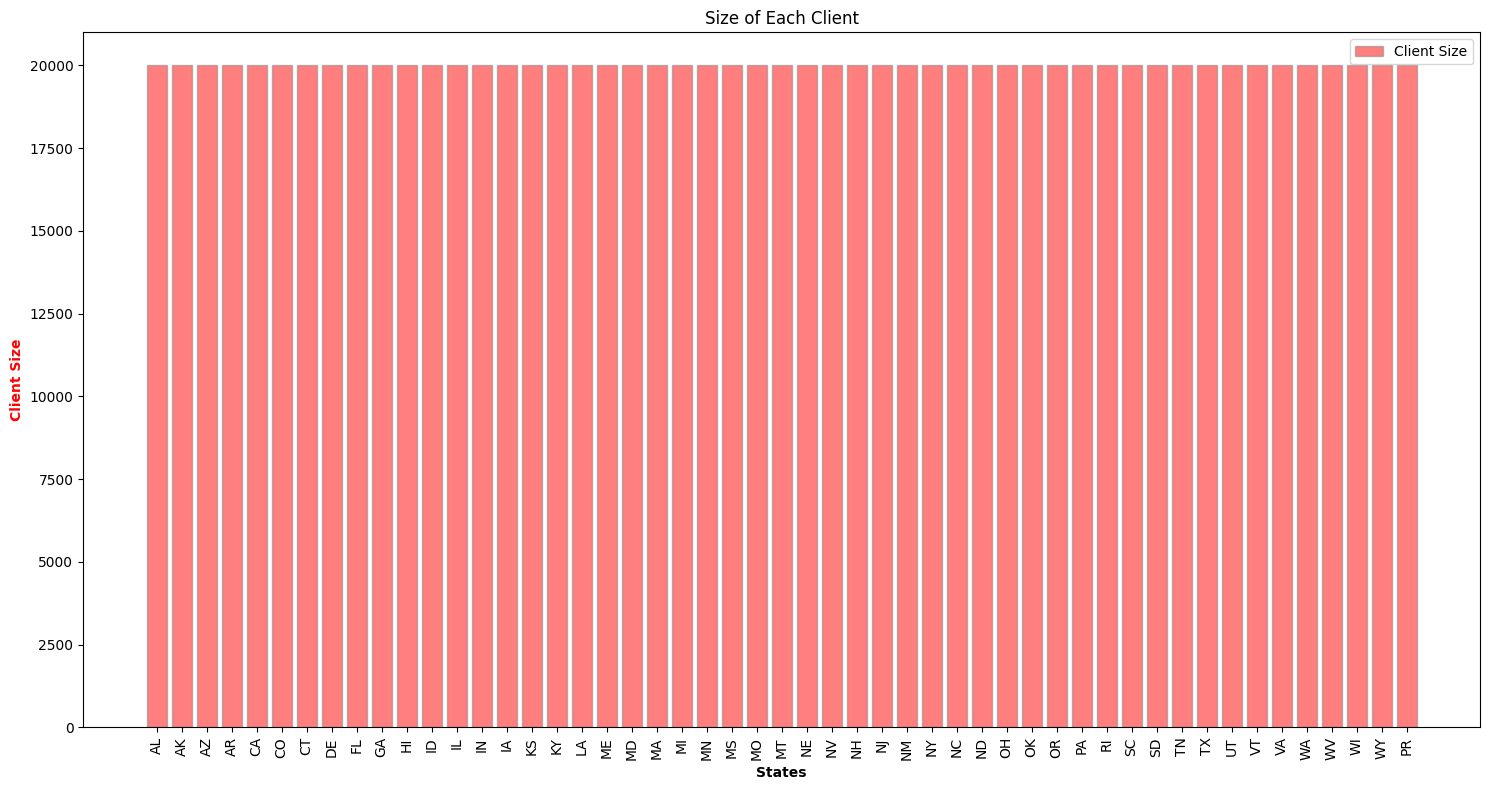

In [19]:
import matplotlib.pyplot as plt

# Plot the accuracy for each client
fig, ax1 = plt.subplots(figsize=(15, 8))

# Set the positions of the bars on the x-axis
r = np.arange(len(states))

# Create the bars for accuracy
bars1 = ax1.bar(r, accuracy_list, color="blue", edgecolor="grey", label="Accuracy")

# Add labels for accuracy
ax1.set_xlabel("States", fontweight="bold")
ax1.set_ylabel("Accuracy", fontweight="bold", color="blue")
ax1.set_title("Accuracy of Each Client")
ax1.set_xticks(r)
ax1.set_xticklabels(states, rotation=90)

# Add legends
ax1.legend(loc="upper right")

# Show the plot
plt.tight_layout()
plt.show()

# Plot the size of each client
fig, ax2 = plt.subplots(figsize=(15, 8))

# Create the bars for client size
client_sizes = [len(df) for df in reduced_df_list]
bars2 = ax2.bar(
    r, client_sizes, color="red", edgecolor="grey", alpha=0.5, label="Client Size"
)

# Add labels for client size
ax2.set_xlabel("States", fontweight="bold")
ax2.set_ylabel("Client Size", fontweight="bold", color="red")
ax2.set_title("Size of Each Client")
ax2.set_xticks(r)
ax2.set_xticklabels(states, rotation=90)

# Add legends
ax2.legend(loc="upper right")

# Show the plot
plt.tight_layout()
plt.show()